This is my recreation of the notebook from Lesson 1 of the Fast.ai course. This is based on [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data). I chose to run this on a Jupyter notebook locally on my Mac, with a different example > Is it a bicycle?

# Step 0: Setup environment and Download packages

In [7]:
import os
! pip install fastai duckduckgo_search fastbook # everything after the "!" is a command that is run in the terminal.

# Step 1: Download images

In [8]:
# from duckduckgo_search import ddg_images
from fastbook import search_images_ddg
# from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images=max_images)

In [9]:
# Search for images
urls = search_images('road bike', max_images=1)
urls[0]

# Click on the URL to check-it out.

Searching for 'road bike'


'http://www.bikesdirect.com/products/dawes/images/lt_2300_blk_x_2100.jpg'

Now that we have a URL, we need to download the image and take a look at it.

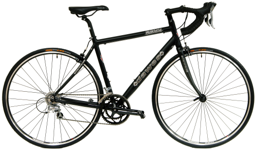

In [10]:
from fastdownload import download_url
dest = 'road_bike.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im= Image.open(dest)
im.to_thumb(256,256)

What should the model contrast it with, we could go with car, truck or motorbike.. but let's give it something trickier. Let's see how it does with Mountain bikes.

Searching for 'mountain bike'


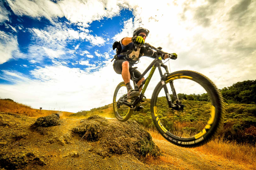

In [11]:
download_url(search_images('mountain bike', max_images=1)[0], 'mountain_bike.jpg', show_progress=True)
Image.open('mountain_bike.jpg').to_thumb(256,256)

Not bad. We're getting decent results. Let's grab a few more examples. We want to get 10 examples of each type of bicycle and put the results in it's own folder.

## Step 1.1: Download images

In [26]:
from pathlib import Path

searches = 'road bike', 'mountain bike'
path = Path('image_examples')
from time import sleep


for o in searches:
    dest = (path/o) # sets the destination folder for the images. E.g image_examples/road_bike.
    dest.mkdir(exist_ok=True, parents=True) # make the directory if it doesn't exist.
    # download_url(search_images(f'{o} photo', max_images=5), dest, show_progress=True)
    download_images(dest, urls=search_images(f'{o} photo')) # this function comes from the fastai.vision.utils module
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in the rain'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in the sun'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} being ridden'))
    resize_images(path/o, max_size=400, dest=path/o)



Searching for 'road bike photo'
Searching for 'road bike in the rain'
Searching for 'road bike in the sun'
Searching for 'road bike being ridden'
Searching for 'mountain bike photo'
Searching for 'mountain bike in the rain'
Searching for 'mountain bike in the sun'
Searching for 'mountain bike being ridden'


In [25]:
#hide
# delete downloaded images
! rm -rf image_examples

# Step 2: Train the model

Some photos may not have downloaded correctly - we should remove them.

In [27]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


2

A `DataLoaders` object is required to train a model. We can create this using a `DataBlock` and the accompanying `dataloaders` method.

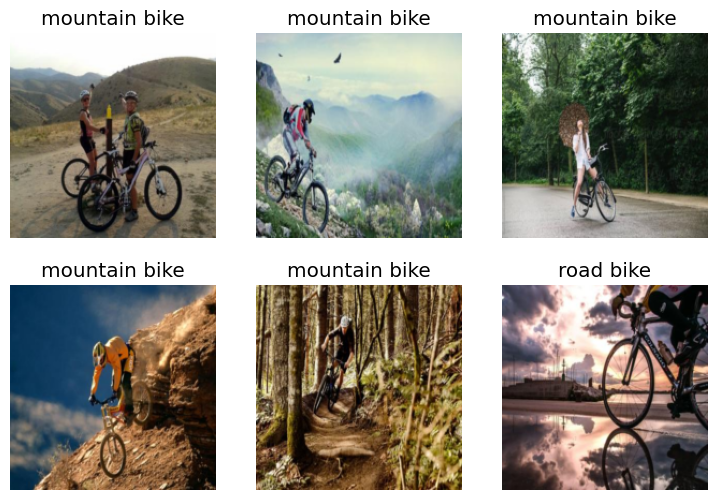

In [28]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32) 

dls.show_batch(max_n=6)



The path variable (set earlier) is being used as an input into the dataloaders method for the DataBlock.

`blocks=(ImageBlock, CategoryBlock)`
Image Block are the images, Category Block are the categories (road bike and mountain bike). These come from the sub folders in the Path.

`get_items=get_image_files` the `get_image_files` function is used to retrieve all images in a path as input.

`splitter=RandomSplitter(valid_pct=0.2, seed=42)` Randomly splits the data into training and validation. 20% us used for validation. See is a randomness parameter.

`get_y=parent_label` The labels / categories / `y` values is the name of the parent folder of each file.

`item_tfms=[Resize(192, method='squish')]` Resize image to 192x192 using the "squish" method.

Now we can train the model - or more specifically. Fine Tune a pre-trained model.

In [31]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.170157,1.367500,0.347826,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.650941,0.907123,0.304348,00:01
1,0.563212,0.880764,0.239130,00:01
2,0.498883,0.918821,0.260870,00:01
3,0.479677,0.833196,0.217391,00:01
4,0.433675,0.815228,0.239130,00:01
5,0.416433,0.876382,0.239130,00:01
6,0.393987,0.900728,0.239130,00:01
7,0.352660,0.907766,0.239130,00:01
8,0.318180,0.893170,0.239130,00:01
9,0.293154,0.890165,0.239130,00:01


The error_rate is a lot higher than expected.

# Step 3: Testing the model

Let's give the model a go. Let's try a few more pictures that we manually source from the web.

In [40]:
# Test 1: Road Bike
what_bike,pred_idx,probs = learn.predict(PILImage.create('road_bike.jpg'))

print(f"Predicted class: {what_bike}")
print(f"Predicted class index: {pred_idx}")
print(f"Prediction outputs: {probs}")
print(f"I can say with a probability of: {probs[0]:.4f} that this is a: {what_bike}.")

Predicted class: road bike
Predicted class index: 1
Prediction outputs: tensor([7.8378e-05, 9.9992e-01])
I can say with a probability of: 0.0001 that this is a: road bike.


In [41]:
# Test 2: Mountain Bike
what_bike,pred_idx,probs = learn.predict(PILImage.create('mountain_bike.jpg'))

print(f"Predicted class: {what_bike}")
print(f"Predicted class index: {pred_idx}")
print(f"Prediction outputs: {probs}")
print(f"I can say with a probability of: {probs[0]:.4f} that this is a: {what_bike}.")

Predicted class: mountain bike
Predicted class index: 0
Prediction outputs: tensor([0.9982, 0.0018])
I can say with a probability of: 0.9982 that this is a: mountain bike.


In [42]:
# Test 3: Car - let's try to break it.
what_bike,pred_idx,probs = learn.predict(PILImage.create('car.jpg'))

print(f"Predicted class: {what_bike}")
print(f"Predicted class index: {pred_idx}")
print(f"Prediction outputs: {probs}")
print(f"I can say with a probability of: {probs[0]:.4f} that this is a: {what_bike}.")

Predicted class: road bike
Predicted class index: 1
Prediction outputs: tensor([0.4938, 0.5062])
I can say with a probability of: 0.4938 that this is a: road bike.


After running a few tests, the model has gotten the prediction right every time. What is strange is that the probability when predicting a mountain bike is always closer to 1.0 and when it's a road bike. It's closer to 0. 

In [19]:
#hide
help(download_images)

# ! ls -l image_examples/road_bike | wc -l

# %pdef fastai.download_images
print(inspect.getsource(download_images))


Help on function download_images in module fastai.vision.utils:

download_images(dest, url_file=None, urls=None, max_pics=1000, n_workers=8, timeout=4, preserve_filename=False)
    Download images listed in text file `url_file` to path `dest`, at most `max_pics`

def download_images(dest, url_file=None, urls=None, max_pics=1000, n_workers=8, timeout=4, preserve_filename=False):
    "Download images listed in text file `url_file` to path `dest`, at most `max_pics`"
    if urls is None: urls = url_file.read_text().strip().split("\n")[:max_pics]
    dest = Path(dest)
    dest.mkdir(exist_ok=True)
    parallel(partial(_download_image_inner, dest, timeout=timeout, preserve_filename=preserve_filename),
             list(enumerate(urls)), n_workers=n_workers, threadpool=True)

